## data processing

In [33]:
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import pearsonr, entropy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# load the data and show the head
data = pd.read_csv("RFLFSODataFull.csv")
data.head()
# check the data type and not null data
data.info()
# Display basic statistical details
data.describe()
# The number of each values of frequency feature
data['Frequency'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91379 entries, 0 to 91378
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FSO_Att                91379 non-null  float64
 1   RFL_Att                91379 non-null  float64
 2   AbsoluteHumidity       91379 non-null  float64
 3   AbsoluteHumidityMax    91379 non-null  float64
 4   AbsoluteHumidityMin    91379 non-null  float64
 5   Distance               91379 non-null  float64
 6   Frequency              91379 non-null  int64  
 7   Particulate            91379 non-null  float64
 8   ParticulateMax         91379 non-null  float64
 9   ParticulateMin         91379 non-null  float64
 10  RainIntensity          91379 non-null  float64
 11  RainIntensityMax       91379 non-null  float64
 12  RainIntensityMin       91379 non-null  float64
 13  RelativeHumidity       91379 non-null  float64
 14  SYNOPCode              91379 non-null  int64  
 15  Te

Frequency
83500000000    45690
73500000000    45689
Name: count, dtype: int64

In [34]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

In [35]:
# the SYNOCode and the best select features
data_by_synop = {
    'data_0': train_data[train_data['SYNOPCode'] == 0],
    'data_3': train_data[train_data['SYNOPCode'] == 3],
    'data_4': train_data[train_data['SYNOPCode'] == 4],
    'data_5': train_data[train_data['SYNOPCode'] == 5],
    'data_6': train_data[train_data['SYNOPCode'] == 6],
    'data_7': train_data[train_data['SYNOPCode'] == 7],
    'data_8': train_data[train_data['SYNOPCode'] == 8]
}

best_features_fso = {
    'data_0': ['Visibility', 'AbsoluteHumidityMin', 'TemperatureMax', 'TemperatureMin', 'VisibilityMin', 'Temperature'],
    'data_3': ['VisibilityMax', 'RelativeHumidity', 'Distance', 'Time'],
    'data_4': ['Distance', 'TemperatureMin', 'TemperatureDifference', 'VisibilityMax', 'ParticulateMin', 'Time'],
    'data_5': ['VisibilityMax', 'Temperature', 'VisibilityMin', 'ParticulateMax'],
    'data_6': ['Visibility', 'AbsoluteHumidityMin', 'TemperatureMax', 'TemperatureMin', 'VisibilityMin', 'Temperature'],
    'data_7': ['Temperature', 'TemperatureDifference', 'Particulate', 'TemperatureMin', 'ParticulateMin'],
    'data_8': ['Distance', 'Visibility', 'AbsoluteHumidityMax', 'VisibilityMax', 'RelativeHumidity']
}

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 7, 10]
}

models_fso = {}


# save the model, predict result and true value
models_fso = {}
total_y_true_fso = []
total_y_pred_fso = []

# train all the subset and predict result
for key, data_subset in data_by_synop.items():
    features = best_features_fso[key]
    X_fso = data_subset[features]
    y_fso = data_subset['FSO_Att']

    # divide the data to train and test
    X_train_fso, X_test_fso, y_train_fso, y_test_fso = train_test_split(
        X_fso, y_fso, test_size=0.3, random_state=42
    )

    # use the mag grid to do the hyperparameter tuning
    rf_fso = RandomForestRegressor(random_state=42)
    grid_search_fso = GridSearchCV(estimator=rf_fso, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search_fso.fit(X_train_fso, y_train_fso)

    # save the best model
    best_model_fso = grid_search_fso.best_estimator_
    models_fso[key] = best_model_fso

    # predict on the test data
    y_pred_fso = best_model_fso.predict(X_test_fso)

    # calculate and print each model's R² and RMSE
    r2 = r2_score(y_test_fso, y_pred_fso)
    rmse = root_mean_squared_error(y_test_fso, y_pred_fso)

    print(f"Best FSO model for {key}: {grid_search_fso.best_params_}")
    print(f"R² for {key}: {r2:.4f}, RMSE: {rmse:.4f}")

    # The predicted and true values are accumulated into the total result
    total_y_true_fso.extend(y_test_fso)
    total_y_pred_fso.extend(y_pred_fso)

    # Add the prediction back to the data set as a new feature
    data_by_synop[key] = data_by_synop[key].copy()
    data_by_synop[key]['FSO_Pred'] = best_model_fso.predict(X_fso)

# Merge all subsets into one complete data set
updated_data = pd.concat(data_by_synop.values())
# === Calculate the total R² and RMSE ===
total_r2_fso = r2_score(total_y_true_fso, total_y_pred_fso)
total_rmse_fso = root_mean_squared_error(total_y_true_fso, total_y_pred_fso)

print(f"Total FSO Model - R2 Score: {total_r2_fso:.4f}")
print(f"Total FSO Model - RMSE: {total_rmse_fso:.4f}")



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_0: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_0: 0.6701, RMSE: 2.0258
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_3: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_3: 0.8630, RMSE: 2.9351
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_4: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_4: 0.9625, RMSE: 0.7895
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_5: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
R² for data_5: 0.8563, RMSE: 1.4001
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_6: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_6: 0.6648, RMSE: 2.5176
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best

In [36]:
best_features_rfl = {
    'data_0': ['Distance', 'Frequency', 'TemperatureMax', 'Time', 'FSO_Pred'],
    'data_3': ['RelativeHumidity', 'TemperatureDifference', 'Time', 'TemperatureMax', 'FSO_Pred'],
    'data_4': ['Visibility', 'Frequency', 'AbsoluteHumidity', 'VisibilityMin', 'Temperature', 'FSO_Pred'],
    'data_5': ['Distance', 'Frequency', 'AbsoluteHumidityMax', 'AbsoluteHumidity', 'ParticulateMax', 'FSO_Pred'],
    'data_6': ['Particulate', 'Distance', 'TemperatureMax', 'VisibilityMin', 'AbsoluteHumidity', 'FSO_Pred'],
    'data_7': ['Time', 'RelativeHumidity', 'RainIntensityMax', 'RainIntensity', 'TemperatureDifference', 'FSO_Pred'],
    'data_8': ['Distance', 'AbsoluteHumidityMax', 'TemperatureDifference', 'Frequency', 'RainIntensityMin', 'FSO_Pred']
}

# save the model and predict result
models_rfl = {}
total_y_true_rfl = []
total_y_pred_rfl = []

# Go through each subset to train and predict the RFL model
for key, data_subset in data_by_synop.items():
    features = best_features_rfl[key]
    X_rfl = data_subset[features]
    y_rfl = data_subset['RFL_Att']

    X_train_rfl, X_test_rfl, y_train_rfl, y_test_rfl = train_test_split(X_rfl, y_rfl, test_size=0.3, random_state=42)

    # Hyperparameter tuning using grid search
    rf_rfl = RandomForestRegressor(random_state=42)
    grid_search_rfl = GridSearchCV(estimator=rf_rfl, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search_rfl.fit(X_train_rfl, y_train_rfl)

    # save the best model
    best_model_rfl = grid_search_rfl.best_estimator_
    models_rfl[key] = best_model_rfl

    # Make predictions on the test set
    y_pred_rfl = best_model_rfl.predict(X_test_rfl)

    total_y_true_rfl.extend(y_test_rfl)
    total_y_pred_rfl.extend(y_pred_rfl)

    print(f"Best RFL model for {key}: {grid_search_rfl.best_params_}")

# calculate the R² and MSE
total_r2_rfl = r2_score(total_y_true_rfl, total_y_pred_rfl)
total_mse_rfl = mean_squared_error(total_y_true_rfl, total_y_pred_rfl)

print(f"Total RFL Model - R2 Score: {total_r2_rfl:.4f}")
print(f"Total RFL Model - Mean Squared Error: {total_mse_rfl:.4f}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_0: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_3: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 100}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_4: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_5: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_6: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_7: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_8: {'max_de

In [37]:
# === 1. Use FSO model for prediction on test set and add FSO_Pred feature === =
for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_fso:  # Check if a corresponding FSO model exists
        fso_model = models_fso[key]
        features_fso = best_features_fso[key]  # Extract the corresponding best features

        # The FSO model is used to predict the test set and FSO_Pred features are added
        fso_pred = fso_model.predict(test_subset[features_fso])
        test_data.loc[test_subset.index, 'FSO_Pred'] = fso_pred

print("The FSO model prediction is complete and the FSO_Pred feature has been added to the test data.")

The FSO model prediction is complete and the FSO_Pred feature has been added to the test data.


In [38]:
# === 2. Use the RFL model on the test set to make predictions and calculate performance ===
total_y_true_rfl = []
total_y_pred_rfl = []

for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_rfl:  # Check if a corresponding RFL model exists
        rfl_model = models_rfl[key]
        features_rfl = best_features_rfl[key]

        # Extract the features and labels of the test set
        X_test_rfl = test_subset[features_rfl]
        y_test_rfl = test_subset['RFL_Att']

        # Use the RFL model for prediction
        y_pred_rfl = rfl_model.predict(X_test_rfl)

        # Accumulate true and predicted values
        total_y_true_rfl.extend(y_test_rfl)
        total_y_pred_rfl.extend(y_pred_rfl)

        print(f"RFL predict finished：{key}")

# === 3. Calculate the overall R² and RMSE ===
total_r2_rfl = r2_score(total_y_true_rfl, total_y_pred_rfl)
total_rmse_rfl = root_mean_squared_error(total_y_true_rfl, total_y_pred_rfl)

print(f"Total RFL Model - R2 Score: {total_r2_rfl:.4f}")
print(f"Total RFL Model - RMSE: {total_rmse_rfl:.4f}")

RFL predict finished：data_0
RFL predict finished：data_3
RFL predict finished：data_4
RFL predict finished：data_5
RFL predict finished：data_6
RFL predict finished：data_7
RFL predict finished：data_8
Total RFL Model - R2 Score: 0.8744
Total RFL Model - RMSE: 1.2139


In [39]:
# === 2. The RFL model is used on the test set to make predictions and calculate performance ===
performance_metrics = {}

for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_rfl:
        rfl_model = models_rfl[key]
        features_rfl = best_features_rfl[key]

        X_test_rfl = test_subset[features_rfl]
        y_test_rfl = test_subset['RFL_Att']

        y_pred_rfl = rfl_model.predict(X_test_rfl)

        # calculate the R² and RMSE
        r2 = r2_score(y_test_rfl, y_pred_rfl)
        rmse = root_mean_squared_error(y_test_rfl, y_pred_rfl)

        # save the result
        performance_metrics[key] = {'R2': r2, 'RMSE': rmse}

        print(f"RFL predict finished：{key}")
        print(f"SYNOPCode {key} - R2 Score: {r2:.4f}")
        print(f"SYNOPCode {key} - RMSE: {rmse:.4f}")

# print the performance for each SYNOPCode
for synop_code, metrics in performance_metrics.items():
    print(f"SYNOPCode {synop_code} - R2 Score: {metrics['R2']:.4f}, RMSE: {metrics['RMSE']:.4f}")


RFL predict finished：data_0
SYNOPCode data_0 - R2 Score: 0.9302
SYNOPCode data_0 - RMSE: 0.6727
RFL predict finished：data_3
SYNOPCode data_3 - R2 Score: 0.9521
SYNOPCode data_3 - RMSE: 0.6761
RFL predict finished：data_4
SYNOPCode data_4 - R2 Score: 0.8477
SYNOPCode data_4 - RMSE: 0.6245
RFL predict finished：data_5
SYNOPCode data_5 - R2 Score: 0.8967
SYNOPCode data_5 - RMSE: 0.9304
RFL predict finished：data_6
SYNOPCode data_6 - R2 Score: 0.7512
SYNOPCode data_6 - RMSE: 1.9972
RFL predict finished：data_7
SYNOPCode data_7 - R2 Score: 0.9134
SYNOPCode data_7 - RMSE: 0.4990
RFL predict finished：data_8
SYNOPCode data_8 - R2 Score: 0.8408
SYNOPCode data_8 - RMSE: 1.2243
SYNOPCode data_0 - R2 Score: 0.9302, RMSE: 0.6727
SYNOPCode data_3 - R2 Score: 0.9521, RMSE: 0.6761
SYNOPCode data_4 - R2 Score: 0.8477, RMSE: 0.6245
SYNOPCode data_5 - R2 Score: 0.8967, RMSE: 0.9304
SYNOPCode data_6 - R2 Score: 0.7512, RMSE: 1.9972
SYNOPCode data_7 - R2 Score: 0.9134, RMSE: 0.4990
SYNOPCode data_8 - R2 Score:

In [40]:
# === 4. Calculate the Pearson correlation coefficient between FSO and RFL predictions ===

# Extract all FSO_Pred and RFL_Pred in the test data as two vectors
fso_pred_all = test_data['FSO_Pred'].values  # FSO predict
rfl_pred_all = np.array(total_y_pred_rfl)  # RFL predict

if len(fso_pred_all) == len(rfl_pred_all):
    # Calculate the Pearson correlation coefficient
    pearson_corr, p_value = pearsonr(fso_pred_all, rfl_pred_all)
    print(f"Pearson Correlation (FSO vs RFL): {pearson_corr:.4f}")
    print(f"P-value: {p_value:.4f}")
else:
    print("The predicted lengths of FSO and RFL are inconsistent, making it impossible to calculate Pearson correlation coefficients.")


Pearson Correlation (FSO vs RFL): -0.0028
P-value: 0.6448


In [41]:
# === 5.1 Use discretization to process continuous data ===
def discretize_data(values, n_bins=10):
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    values = values.reshape(-1, 1)
    return est.fit_transform(values).flatten()

# Discretize the predicted values of FSO and RFL
fso_discretized = discretize_data(fso_pred_all, n_bins=10)
rfl_discretized = discretize_data(rfl_pred_all, n_bins=10)

# === 5.2 Calculate the entropy of a single variable ===
def calculate_entropy(values):
    _, counts = np.unique(values, return_counts=True)
    return entropy(counts)

entropy_fso = calculate_entropy(fso_discretized)
entropy_rfl = calculate_entropy(rfl_discretized)

print(f"Entropy of FSO Predictions: {entropy_fso:.4f}")
print(f"Entropy of RFL Predictions: {entropy_rfl:.4f}")

# === 5.3 Calculate the joint entropy ===
def joint_entropy(x, y):
    xy = np.array(list(zip(x, y)))
    _, counts = np.unique(xy, axis=0, return_counts=True)
    return entropy(counts)

joint_entropy_fso_rfl = joint_entropy(fso_discretized, rfl_discretized)

print(f"Joint Entropy (FSO & RFL): {joint_entropy_fso_rfl:.4f}")

# === 5.4 Calculate mutual information ===
mutual_info = entropy_fso + entropy_rfl - joint_entropy_fso_rfl

print(f"Mutual Information (FSO vs RFL): {mutual_info:.4f}")

Entropy of FSO Predictions: 1.5280
Entropy of RFL Predictions: 1.1202
Joint Entropy (FSO & RFL): 2.6470
Mutual Information (FSO vs RFL): 0.0011


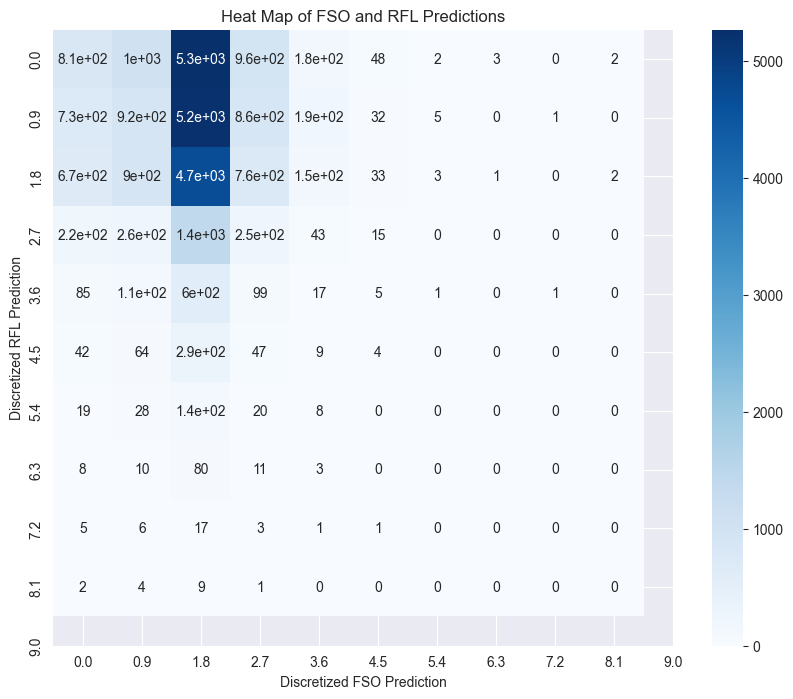

In [42]:
# === 6. Heatmap visualization ===
joint_counts, x_edges, y_edges = np.histogram2d(fso_discretized, rfl_discretized, bins=10)
plt.figure(figsize=(10, 8))
sns.heatmap(joint_counts, annot=True, cmap='Blues', xticklabels=np.round(x_edges, 2), yticklabels=np.round(y_edges, 2))
plt.title('Heat Map of FSO and RFL Predictions')
plt.xlabel('Discretized FSO Prediction')
plt.ylabel('Discretized RFL Prediction')
plt.show()

In [43]:
correlation_coeffs = []
info_ratios = []

# Traversing every weather condition (SYNOPCode)
for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_rfl:  # Check if a corresponding RFL model exists
        # Extract RFL model
        rfl_model = models_rfl[key]

        # Extract FSO predicted values and corresponding RFL true labels and predicted values
        fso_pred = test_subset['FSO_Pred'].values
        X_test_rfl = test_subset[best_features_rfl[key]]
        rfl_pred = rfl_model.predict(X_test_rfl)

        # Make sure the length is consistent
        if len(fso_pred) == len(rfl_pred):
            # Calculate the Pearson correlation coefficient
            pearson_corr, _ = pearsonr(fso_pred, rfl_pred)
            correlation_coeffs.append((key, pearson_corr))

            # Calculate univariate entropy
            fso_discretized = discretize_data(fso_pred, n_bins=10)
            rfl_discretized = discretize_data(rfl_pred, n_bins=10)
            entropy_fso = calculate_entropy(fso_discretized)
            entropy_rfl = calculate_entropy(rfl_discretized)

            # Calculate joint entropy and mutual information
            joint_entropy_value = joint_entropy(fso_discretized, rfl_discretized)
            mutual_info_value = entropy_fso + entropy_rfl - joint_entropy_value

            # Calculate the mutual information ratio and add to the list
            if joint_entropy_value != 0:
                info_ratio = mutual_info_value / joint_entropy_value
            else:
                info_ratio = 0
            info_ratios.append((key, info_ratio))

# Print results
print("Correlation Coefficients by SYNOPCode:")
for key, coeff in correlation_coeffs:
    print(f"SYNOPCode {key}: {coeff:.4f}")

print("\nMutual Information Ratios by SYNOPCode:")
for key, ratio in info_ratios:
    print(f"SYNOPCode {key}: {ratio:.4f}")


Correlation Coefficients by SYNOPCode:
SYNOPCode data_0: -0.1536
SYNOPCode data_3: -0.3370
SYNOPCode data_4: 0.5807
SYNOPCode data_5: -0.2254
SYNOPCode data_6: 0.3004
SYNOPCode data_7: 0.8773
SYNOPCode data_8: -0.2597

Mutual Information Ratios by SYNOPCode:
SYNOPCode data_0: 0.0933
SYNOPCode data_3: 0.2234
SYNOPCode data_4: 0.2237
SYNOPCode data_5: 0.1268
SYNOPCode data_6: 0.0663
SYNOPCode data_7: 0.2803
SYNOPCode data_8: 0.1226


In [44]:
correlation_coeffs

[('data_0', -0.1536225153322339),
 ('data_3', -0.3369686312589675),
 ('data_4', 0.5807489023164777),
 ('data_5', -0.22538776305891026),
 ('data_6', 0.30036303543628895),
 ('data_7', 0.8772868754507616),
 ('data_8', -0.25970386991668)]

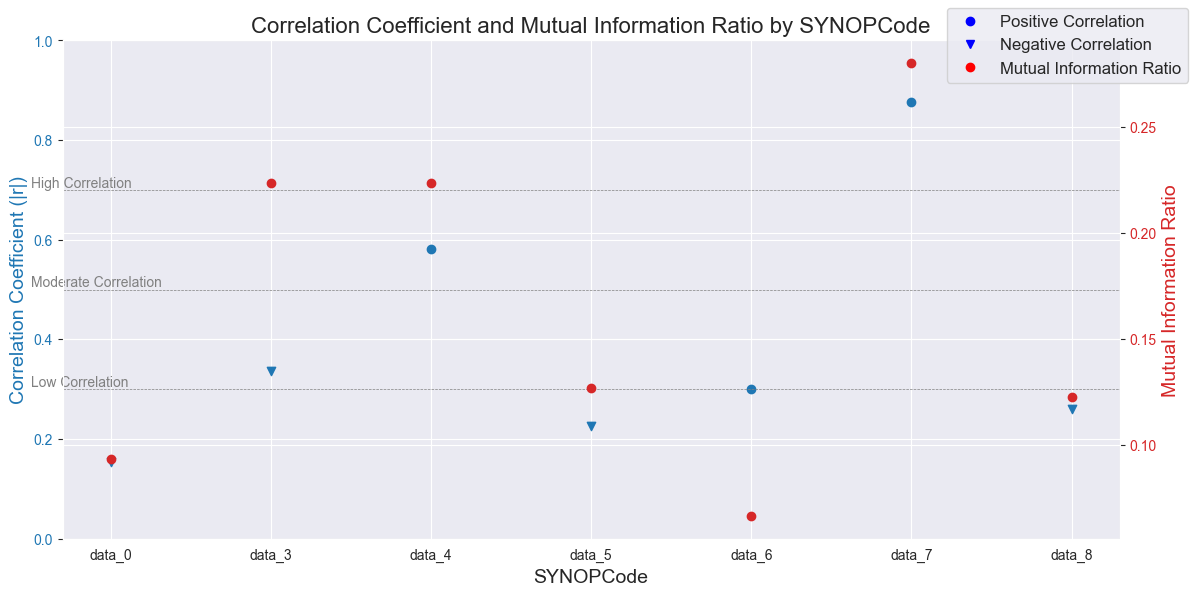

In [45]:
# Extract SYNOPCode and corresponding values
synop_codes = [key for key, _ in correlation_coeffs]
correlation_values = [abs(coeff) for _, coeff in correlation_coeffs]  # 使用绝对值
info_ratio_values = [ratio for _, ratio in info_ratios]

# Create a chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot a scatter plot of the correlation coefficients (use shapes to distinguish positive and negative values)
color = 'tab:blue'
ax1.set_xlabel('SYNOPCode', fontsize=14)
ax1.set_ylabel('Correlation Coefficient (|r|)', color=color, fontsize=14)

for synop_code, corr_value, original_corr in zip(synop_codes, correlation_values, [coeff for _, coeff in correlation_coeffs]):
    marker = 'o' if original_corr >= 0 else 'v'
    ax1.scatter(synop_code, corr_value, color=color, marker=marker, label='Correlation Coeff.')

ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor=color)

correlation_levels = [0.7, 0.5, 0.3]
labels = ['High Correlation', 'Moderate Correlation', 'Low Correlation']

for level, label in zip(correlation_levels, labels):
    ax1.axhline(y=level, color='gray', linestyle='--', linewidth=0.5)
    ax1.text(-0.5, level, label, color='gray', verticalalignment='bottom', fontsize=10)

# Create a second vertical axis for mutual information ratios
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Mutual Information Ratio', color=color, fontsize=14)
ax2.scatter(synop_codes, info_ratio_values, color=color, label='Mutual Information Ratio')
ax2.tick_params(axis='y', labelcolor=color)

# Add legend
handles1 = [plt.Line2D([0], [0], marker='o', color='blue', label='Positive Correlation', linestyle='None'),
            plt.Line2D([0], [0], marker='v', color='blue', label='Negative Correlation', linestyle='None')]
handles2 = [plt.Line2D([0], [0], marker='o', color='red', label='Mutual Information Ratio', linestyle='None')]

fig.legend(handles=handles1 + handles2, loc='upper right', fontsize=12)

# Chart title
plt.title('Correlation Coefficient and Mutual Information Ratio by SYNOPCode', fontsize=16)
plt.tight_layout()
plt.show()

In [46]:
# Define data set and best feature set (RFL does not require RF_Pred)
data_by_synop = {
    'data_0': train_data[train_data['SYNOPCode'] == 0],
    'data_3': train_data[train_data['SYNOPCode'] == 3],
    'data_4': train_data[train_data['SYNOPCode'] == 4],
    'data_5': train_data[train_data['SYNOPCode'] == 5],
    'data_6': train_data[train_data['SYNOPCode'] == 6],
    'data_7': train_data[train_data['SYNOPCode'] == 7],
    'data_8': train_data[train_data['SYNOPCode'] == 8]
}

best_features_rfl = {
    'data_0': ['Distance', 'Frequency', 'TemperatureMax', 'Time'],
    'data_3': ['RelativeHumidity', 'TemperatureDifference', 'Time', 'TemperatureMax'],
    'data_4': ['Visibility', 'Frequency', 'AbsoluteHumidity', 'VisibilityMin', 'Temperature'],
    'data_5': ['Distance', 'Frequency', 'AbsoluteHumidityMax', 'AbsoluteHumidity', 'ParticulateMax'],
    'data_6': ['Particulate', 'Distance', 'TemperatureMax', 'VisibilityMin', 'AbsoluteHumidity'],
    'data_7': ['Time', 'RelativeHumidity', 'RainIntensityMax', 'RainIntensity', 'TemperatureDifference'],
    'data_8': ['Distance', 'AbsoluteHumidityMax', 'TemperatureDifference', 'Frequency', 'RainIntensityMin']
}

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 7, 10]
}

# Store models and predictions
models_rfl = {}
total_y_true_rfl = []
total_y_pred_rfl = []

# === RFL model training and prediction ===
for key, data_subset in data_by_synop.items():
    features = best_features_rfl[key]
    X_rfl = data_subset[features]
    y_rfl = data_subset['RFL_Att']

    # Split the data into training sets and test sets
    X_train_rfl, X_test_rfl, y_train_rfl, y_test_rfl = train_test_split(
        X_rfl, y_rfl, test_size=0.3, random_state=42
    )

    # Use grid search for hyperparameter tuning
    rf_rfl = RandomForestRegressor(random_state=42)
    grid_search_rfl = GridSearchCV(estimator=rf_rfl, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search_rfl.fit(X_train_rfl, y_train_rfl)

    # Get the best model and save
    best_model_rfl = grid_search_rfl.best_estimator_
    models_rfl[key] = best_model_rfl

    # Make predictions on the test set
    y_pred_rfl = best_model_rfl.predict(X_test_rfl)

    # Calculate and print the R² and RMSE for each model
    r2 = r2_score(y_test_rfl, y_pred_rfl)
    rmse = root_mean_squared_error(y_test_rfl, y_pred_rfl)  # RMSE

    print(f"Best RFL model for {key}: {grid_search_rfl.best_params_}")
    print(f"R² for {key}: {r2:.4f}, RMSE: {rmse:.4f}")

    # Accumulate the predicted and true values into the total result
    total_y_true_rfl.extend(y_test_rfl)
    total_y_pred_rfl.extend(y_pred_rfl)

    # Add the prediction back to the dataset as a new feature
    data_by_synop[key] = data_by_synop[key].copy()
    data_by_synop[key]['RFL_Pred'] = best_model_rfl.predict(X_rfl)

# Merge all subsets into one complete dataset for FSO training
updated_data = pd.concat(data_by_synop.values())

# === Calculate the total R² and RMSE ===
total_r2_rfl = r2_score(total_y_true_rfl, total_y_pred_rfl)
total_rmse_rfl = root_mean_squared_error(total_y_true_rfl, total_y_pred_rfl)

print(f"Total RFL Model - R2 Score: {total_r2_rfl:.4f}")
print(f"Total RFL Model - RMSE: {total_rmse_rfl:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_0: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_0: 0.9284, RMSE: 0.6833
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_3: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_3: 0.9630, RMSE: 0.5234
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_4: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
R² for data_4: 0.7626, RMSE: 0.9381
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_5: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_5: 0.8879, RMSE: 0.9428
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best RFL model for data_6: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_6: 0.7392, RMSE: 2.0582
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best R

In [47]:
best_features_fso = {
    'data_0': ['Visibility', 'AbsoluteHumidityMin', 'TemperatureMax', 'TemperatureMin', 'VisibilityMin', 'Temperature', 'RFL_Pred'],
    'data_3': ['VisibilityMax', 'RelativeHumidity', 'Distance', 'Time', 'RFL_Pred'],
    'data_4': ['Distance', 'TemperatureMin', 'TemperatureDifference', 'VisibilityMax', 'ParticulateMin', 'Time', 'RFL_Pred'],
    'data_5': ['VisibilityMax', 'Temperature', 'VisibilityMin', 'ParticulateMax', 'RFL_Pred'],
    'data_6': ['Visibility', 'AbsoluteHumidityMin', 'TemperatureMax', 'TemperatureMin', 'VisibilityMin', 'Temperature', 'RFL_Pred'],
    'data_7': ['Temperature', 'TemperatureDifference', 'Particulate', 'TemperatureMin', 'ParticulateMin', 'RFL_Pred'],
    'data_8': ['Distance', 'Visibility', 'AbsoluteHumidityMax', 'VisibilityMax', 'RelativeHumidity', 'RFL_Pred']
}

# Store FSO models and predictions
models_fso = {}
total_y_true_fso = []
total_y_pred_fso = []

# === 3. Train the FSO model and save the best model ===
for key, data_subset in data_by_synop.items():
    features = best_features_fso[key]
    X_fso = data_subset[features]
    y_fso = data_subset['FSO_Att']

    # Split training set and test set
    X_train_fso, X_test_fso, y_train_fso, y_test_fso = train_test_split(X_fso, y_fso, test_size=0.3, random_state=42)

    # Use grid search for hyperparameter tuning
    rf_fso = RandomForestRegressor(random_state=42)
    grid_search_fso = GridSearchCV(estimator=rf_fso, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search_fso.fit(X_train_fso, y_train_fso)

    # Save the best model
    best_model_fso = grid_search_fso.best_estimator_
    models_fso[key] = best_model_fso

    # Make predictions on the test set
    y_pred_fso = best_model_fso.predict(X_test_fso)

    # Accumulate true and predicted values
    total_y_true_fso.extend(y_test_fso)
    total_y_pred_fso.extend(y_pred_fso)

    print(f"Best FSO model for {key}: {grid_search_fso.best_params_}")

# Calculate the overall R² and RMSE
total_r2_fso = r2_score(total_y_true_fso, total_y_pred_fso)
total_rmse_fso = root_mean_squared_error(total_y_true_fso, total_y_pred_fso)

print(f"Total FSO Model - R2 Score: {total_r2_fso:.4f}")
print(f"Total FSO Model - RMSE: {total_rmse_fso:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_0: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_3: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_4: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_5: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_6: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_7: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 100}
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best FSO model for data_8: {'max_de

In [48]:
# === 1. Make predictions using the RFL model on the test set and add the RFL_Pred feature ===
for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_rfl:  # Check if a corresponding RFL model exists
        rfl_model = models_rfl[key]
        features_rfl = best_features_rfl[key]

        # Use the RFL model to make predictions on the test set and add RFL_Pred features
        rfl_pred = rfl_model.predict(test_subset[features_rfl])
        test_data.loc[test_subset.index, 'RFL_Pred'] = rfl_pred

print("The RFL model prediction is complete and the RFL_Pred feature has been added to the test data.")

The RFL model prediction is complete and the RFL_Pred feature has been added to the test data.


In [49]:
# === 2. The FSO model is used on the test set for prediction and performance is calculated ===
total_y_true_fso = []
total_y_pred_fso = []

for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_fso:  # Check if a corresponding FSO model exists
        fso_model = models_fso[key]
        features_fso = best_features_fso[key]

        # Extract the features and labels of the test set
        X_test_fso = test_subset[features_fso]
        y_test_fso = test_subset['FSO_Att']

        # Prediction using FSO model
        y_pred_fso = fso_model.predict(X_test_fso)

        # Accumulate true and predicted values
        total_y_true_fso.extend(y_test_fso)
        total_y_pred_fso.extend(y_pred_fso)

        print(f"FSO predict complete：{key}")

# === 3. Calculate the total R² and RMSE ===
total_r2_fso = r2_score(total_y_true_fso, total_y_pred_fso)
total_rmse_fso = root_mean_squared_error(total_y_true_fso, total_y_pred_fso)

print(f"Total FSO Model - R2 Score: {total_r2_fso:.4f}")
print(f"Total FSO Model - RMSE: {total_rmse_fso:.4f}")

FSO predict complete：data_0
FSO predict complete：data_3
FSO predict complete：data_4
FSO predict complete：data_5
FSO predict complete：data_6
FSO predict complete：data_7
FSO predict complete：data_8
Total FSO Model - R2 Score: 0.8220
Total FSO Model - RMSE: 1.6321


In [50]:
# === 2. Use FSO model on test set for prediction and calculate performance ===
performance_metrics_fso = {}

for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_fso:  # Check if a corresponding FSO model exists
        fso_model = models_fso[key]
        features_fso = best_features_fso[key]  # Extract the corresponding best features

        # Extract the features and labels of the test set
        X_test_fso = test_subset[features_fso]
        y_test_fso = test_subset['FSO_Att']

        # Prediction using FSO model
        y_pred_fso = fso_model.predict(X_test_fso)

        # Calculate the R² and RMSE for each SYNOPCode
        r2 = r2_score(y_test_fso, y_pred_fso)
        rmse = root_mean_squared_error(y_test_fso, y_pred_fso)

        # Store the result in a dictionary
        performance_metrics_fso[key] = {'R2': r2, 'RMSE': rmse}

        print(f"FSO predict complete：{key}")
        print(f"SYNOPCode {key} - R2 Score: {r2:.4f}")
        print(f"SYNOPCode {key} - RMSE: {rmse:.4f}")

# Prints the performance of each SYNOPCode
for synop_code, metrics in performance_metrics_fso.items():
    print(f"SYNOPCode {synop_code} - R2 Score: {metrics['R2']:.4f}, RMSE: {metrics['RMSE']:.4f}")


FSO predict complete：data_0
SYNOPCode data_0 - R2 Score: 0.7767
SYNOPCode data_0 - RMSE: 1.6360
FSO predict complete：data_3
SYNOPCode data_3 - R2 Score: 0.9155
SYNOPCode data_3 - RMSE: 2.5595
FSO predict complete：data_4
SYNOPCode data_4 - R2 Score: 0.9676
SYNOPCode data_4 - RMSE: 0.6991
FSO predict complete：data_5
SYNOPCode data_5 - R2 Score: 0.8479
SYNOPCode data_5 - RMSE: 1.4071
FSO predict complete：data_6
SYNOPCode data_6 - R2 Score: 0.8403
SYNOPCode data_6 - RMSE: 1.7088
FSO predict complete：data_7
SYNOPCode data_7 - R2 Score: 0.9328
SYNOPCode data_7 - RMSE: 1.5023
FSO predict complete：data_8
SYNOPCode data_8 - R2 Score: 0.9018
SYNOPCode data_8 - RMSE: 1.1998
SYNOPCode data_0 - R2 Score: 0.7767, RMSE: 1.6360
SYNOPCode data_3 - R2 Score: 0.9155, RMSE: 2.5595
SYNOPCode data_4 - R2 Score: 0.9676, RMSE: 0.6991
SYNOPCode data_5 - R2 Score: 0.8479, RMSE: 1.4071
SYNOPCode data_6 - R2 Score: 0.8403, RMSE: 1.7088
SYNOPCode data_7 - R2 Score: 0.9328, RMSE: 1.5023
SYNOPCode data_8 - R2 Score:

In [51]:
# === 4. Calculate the Pearson correlation coefficient between RFL and FSO predictions ===

# Extract all RFL_Pred and FSO_Pred (i.e. y_pred_fso) from the test data as two vectors
rfl_pred_all = test_data['RFL_Pred'].values  # RFL predict
fso_pred_all = np.array(total_y_pred_fso)  # FSO predict

if len(rfl_pred_all) == len(fso_pred_all):
    # Calculate the Pearson correlation coefficient
    pearson_corr, p_value = pearsonr(rfl_pred_all, fso_pred_all)
    print(f"Pearson Correlation (RFL vs FSO): {pearson_corr:.4f}")
    print(f"P-value: {p_value:.4f}")
else:
    print("The predicted lengths of the RFL and FSO are inconsistent and the Pearson correlation coefficients cannot be calculated.")

Pearson Correlation (RFL vs FSO): 0.0037
P-value: 0.5379


In [52]:
# === 5.1 Processing continuous data using discretization ===
def discretize_data(values, n_bins=10):
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    values = values.reshape(-1, 1)
    return est.fit_transform(values).flatten()

# Discretize the predicted values of RFL and FSO
rfl_discretized = discretize_data(rfl_pred_all, n_bins=10)
fso_discretized = discretize_data(fso_pred_all, n_bins=10)

# === 5.2 Calculate the entropy of a single variable ===
def calculate_entropy(values):
    _, counts = np.unique(values, return_counts=True)
    return entropy(counts)

entropy_rfl = calculate_entropy(rfl_discretized)
entropy_fso = calculate_entropy(fso_discretized)

print(f"Entropy of RFL Predictions: {entropy_rfl:.4f}")
print(f"Entropy of FSO Predictions: {entropy_fso:.4f}")

# === 5.3 Calculate the joint entropy ===
def joint_entropy(x, y):
    xy = np.array(list(zip(x, y)))
    _, counts = np.unique(xy, axis=0, return_counts=True)
    return entropy(counts)

joint_entropy_rfl_fso = joint_entropy(rfl_discretized, fso_discretized)

print(f"Joint Entropy (RFL & FSO): {joint_entropy_rfl_fso:.4f}")

# === 5.4 Calculating mutual information ===
mutual_info = entropy_rfl + entropy_fso - joint_entropy_rfl_fso
print(f"Mutual Information (FSO vs RFL): {mutual_info:.4f}")

Entropy of RFL Predictions: 1.0915
Entropy of FSO Predictions: 1.5159
Joint Entropy (RFL & FSO): 2.6064
Mutual Information (FSO vs RFL): 0.0009


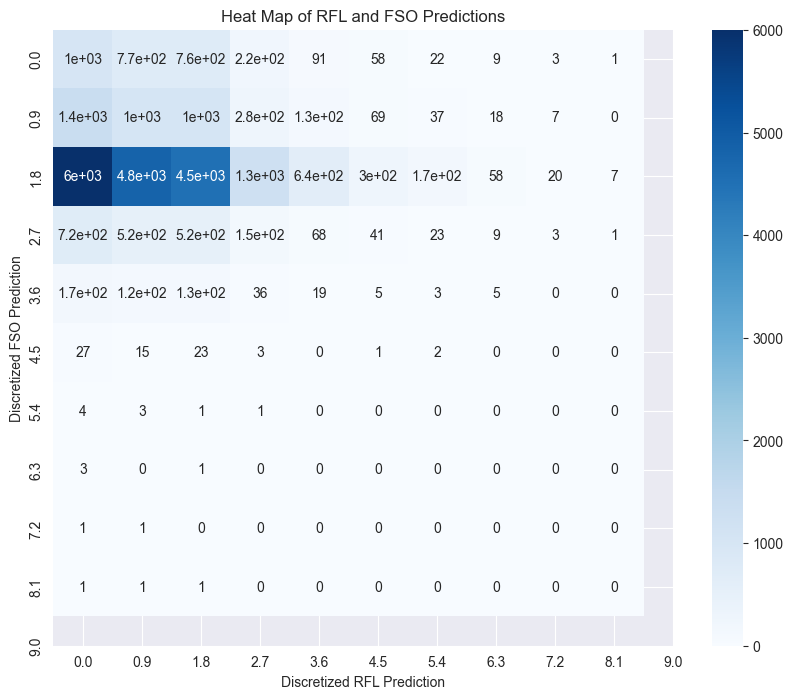

In [53]:
# === 6. Heatmap visualization ===
joint_counts, x_edges, y_edges = np.histogram2d(rfl_discretized, fso_discretized, bins=10)
plt.figure(figsize=(10, 8))
sns.heatmap(joint_counts, annot=True, cmap='Blues', xticklabels=np.round(x_edges, 2), yticklabels=np.round(y_edges, 2))
plt.title('Heat Map of RFL and FSO Predictions')
plt.xlabel('Discretized RFL Prediction')
plt.ylabel('Discretized FSO Prediction')
plt.show()

In [54]:
correlation_coeffs = []
info_ratios = []

for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_fso:  # Check if a corresponding FSO model exists
        # Extract FSO model
        fso_model = models_fso[key]

        # Extract the RFL predicted value and the corresponding FSO true label and predicted value
        rfl_pred = test_subset['RFL_Pred'].values
        X_test_fso = test_subset[best_features_fso[key]]
        fso_pred = fso_model.predict(X_test_fso)

        # Ensure consistent length
        if len(rfl_pred) == len(fso_pred):
            # Calculate the Pearson correlation coefficient
            pearson_corr, _ = pearsonr(rfl_pred, fso_pred)
            correlation_coeffs.append((key, pearson_corr))

            # Calculate univariate entropy
            rfl_discretized = discretize_data(rfl_pred, n_bins=10)
            fso_discretized = discretize_data(fso_pred, n_bins=10)
            entropy_rfl = calculate_entropy(rfl_discretized)
            entropy_fso = calculate_entropy(fso_discretized)

            # Calculate joint entropy and mutual information
            joint_entropy_value = joint_entropy(rfl_discretized, fso_discretized)
            mutual_info_value = entropy_rfl + entropy_fso - joint_entropy_value

            # Calculate the mutual information ratio and add it to the list
            if joint_entropy_value != 0:
                info_ratio = mutual_info_value / joint_entropy_value
            else:
                info_ratio = 0
            info_ratios.append((key, info_ratio))

# print the result
print("Correlation Coefficients by SYNOPCode:")
for key, coeff in correlation_coeffs:
    print(f"SYNOPCode {key}: {coeff:.4f}")

print("\nMutual Information Ratios by SYNOPCode:")
for key, ratio in info_ratios:
    print(f"SYNOPCode {key}: {ratio:.4f}")


Correlation Coefficients by SYNOPCode:
SYNOPCode data_0: -0.3433
SYNOPCode data_3: -0.4177
SYNOPCode data_4: 0.5418
SYNOPCode data_5: -0.2572
SYNOPCode data_6: 0.4001
SYNOPCode data_7: 0.8878
SYNOPCode data_8: -0.3094

Mutual Information Ratios by SYNOPCode:
SYNOPCode data_0: 0.1030
SYNOPCode data_3: 0.2080
SYNOPCode data_4: 0.2023
SYNOPCode data_5: 0.1309
SYNOPCode data_6: 0.0935
SYNOPCode data_7: 0.2987
SYNOPCode data_8: 0.1193


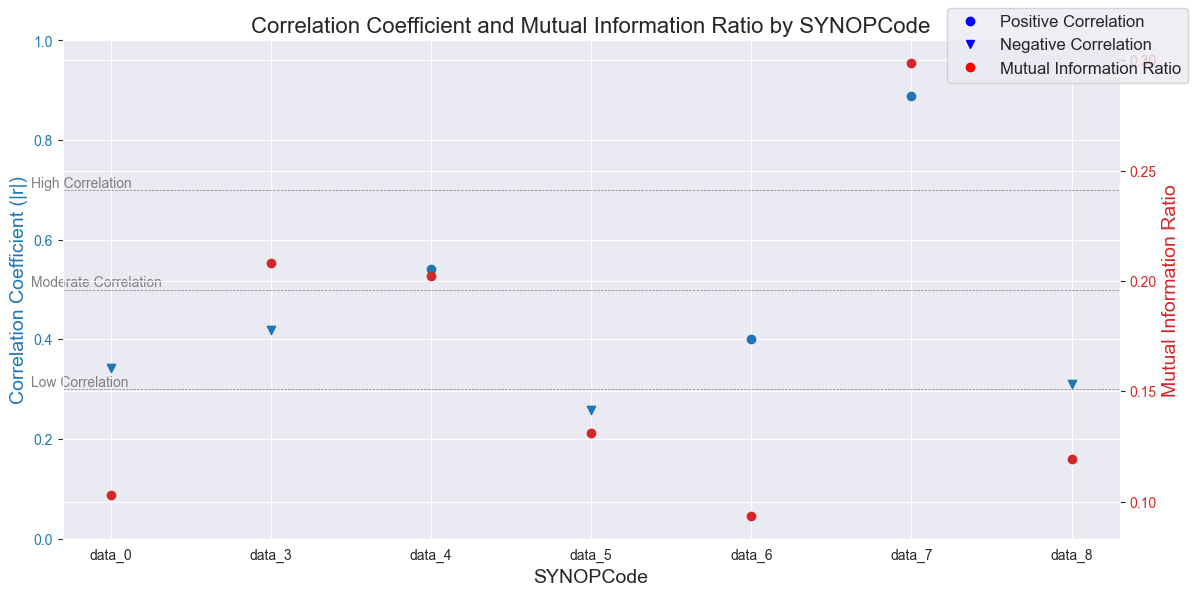

In [55]:
# Extract SYNOPCode and corresponding values
synop_codes = [key for key, _ in correlation_coeffs]
correlation_values = [abs(coeff) for _, coeff in correlation_coeffs]  # Use absolute value
info_ratio_values = [ratio for _, ratio in info_ratios]

# Create chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot a scatter plot of the correlation coefficients (using shapes to distinguish positive and negative)
color = 'tab:blue'
ax1.set_xlabel('SYNOPCode', fontsize=14)
ax1.set_ylabel('Correlation Coefficient (|r|)', color=color, fontsize=14)

for synop_code, corr_value, original_corr in zip(synop_codes, correlation_values, [coeff for _, coeff in correlation_coeffs]):
    marker = 'o' if original_corr >= 0 else 'v'  # Circle for positive values and lower triangle for negative values
    ax1.scatter(synop_code, corr_value, color=color, label='Correlation Coeff.', marker=marker)

ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor=color)

correlation_levels = [0.7, 0.5, 0.3]
labels = ['High Correlation', 'Moderate Correlation', 'Low Correlation']

for level, label in zip(correlation_levels, labels):
    ax1.axhline(y=level, color='gray', linestyle='--', linewidth=0.5)
    ax1.text(-0.5, level, label, color='gray', verticalalignment='bottom', fontsize=10)

# Create a second vertical axis for mutual information ratios
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Mutual Information Ratio', color=color, fontsize=14)
ax2.scatter(synop_codes, info_ratio_values, color=color, label='Mutual Information Ratio')
ax2.tick_params(axis='y', labelcolor=color)

handles1 = [plt.Line2D([0], [0], marker='o', color='blue', label='Positive Correlation', linestyle='None'),
            plt.Line2D([0], [0], marker='v', color='blue', label='Negative Correlation', linestyle='None')]
handles2 = [plt.Line2D([0], [0], marker='o', color='red', label='Mutual Information Ratio', linestyle='None')]

fig.legend(handles=handles1 + handles2, loc='upper right', fontsize=12)

# Chart title
plt.title('Correlation Coefficient and Mutual Information Ratio by SYNOPCode', fontsize=16)
plt.tight_layout()
plt.show()

In [56]:
best_features_fso = {
    'data_0': ['Visibility', 'AbsoluteHumidityMin', 'TemperatureMax', 'TemperatureMin', 'VisibilityMin', 'Temperature'],
    'data_3': ['VisibilityMax', 'RelativeHumidity', 'Distance', 'Time'],
    'data_4': ['Distance', 'TemperatureMin', 'TemperatureDifference', 'VisibilityMax', 'ParticulateMin', 'Time'],
    'data_5': ['VisibilityMax', 'Temperature', 'VisibilityMin', 'ParticulateMax'],
    'data_6': ['Visibility', 'AbsoluteHumidityMin', 'TemperatureMax', 'TemperatureMin', 'VisibilityMin', 'Temperature'],
    'data_7': ['Temperature', 'TemperatureDifference', 'Particulate', 'TemperatureMin', 'ParticulateMin'],
    'data_8': ['Distance', 'Visibility', 'AbsoluteHumidityMax', 'VisibilityMax', 'RelativeHumidity']
}

best_features_rfl = {
    'data_0': ['Distance', 'Frequency', 'TemperatureMax', 'Time'],
    'data_3': ['RelativeHumidity', 'TemperatureDifference', 'Time', 'Temperature', 'AbsoluteHumidity', 'TemperatureMin', 'AbsoluteHumidityMin', 'TemperatureMax'],
    'data_4': ['Visibility', 'Frequency', 'AbsoluteHumidity', 'VisibilityMin', 'Temperature', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin'],
    'data_5': ['Distance', 'Frequency', 'AbsoluteHumidityMax', 'AbsoluteHumidity', 'ParticulateMax', 'VisibilityMin', 'VisibilityMax'],
    'data_6': ['Particulate', 'Distance', 'TemperatureMax', 'VisibilityMin', 'AbsoluteHumidity', 'RainIntensity', 'AbsoluteHumidityMax', 'RainIntensityMax', 'Temperature'],
    'data_7': ['Time', 'RelativeHumidity', 'RainIntensityMax', 'RainIntensity', 'TemperatureDifference', 'RainIntensityMin'],
    'data_8': ['Distance', 'AbsoluteHumidityMax', 'TemperatureDifference', 'Frequency', 'RainIntensityMin', 'RainIntensity', 'RainIntensityMax', 'WindSpeed', 'Temperature']
}

# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 7, 10]
}

models_rfl, models_fso = {}, {}
total_y_true_rfl, total_y_pred_rfl = [], []
total_y_true_fso, total_y_pred_fso = [], []


In [57]:
def train_model(data, features, target, param_grid, model_name):
    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # random forest model
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    print(f"Grid search results for {model_name}:")
    results = pd.DataFrame(grid_search.cv_results_)
    print(results[['param_n_estimators', 'param_max_features', 'param_max_depth', 'mean_test_score']])

    return grid_search.best_estimator_, X_test, y_test

# Create data dictionaries grouped by SYNOPCode
data_by_synop = {f"data_{i}": train_data[train_data['SYNOPCode'] == i] for i in [0, 3, 4, 5, 6, 7, 8]}

# Traverse each SYNOPCode training RFL model
for i in [0, 3, 4, 5, 6, 7, 8]:
    data_subset = data_by_synop[f'data_{i}']
    model, X_test, y_test = train_model(
        data_subset,
        best_features_rfl[f'data_{i}'],
        'RFL_Att',
        param_grid,
        f'RFL data_{i}'
    )
    models_rfl[f'data_{i}'] = model
    y_pred = model.predict(X_test)
    total_y_true_rfl.extend(y_test)
    total_y_pred_rfl.extend(y_pred)

# Traverse each SYNOPCode to train the FSO model
for i in [0, 3, 4, 5, 6, 7, 8]:
    data_subset = data_by_synop[f'data_{i}']
    model, X_test, y_test = train_model(
        data_subset,
        best_features_fso[f'data_{i}'],
        'FSO_Att',
        param_grid,
        f'FSO data_{i}'
    )
    models_fso[f'data_{i}'] = model
    y_pred = model.predict(X_test)
    total_y_true_fso.extend(y_test)
    total_y_pred_fso.extend(y_pred)

# Calculate total performance metrics
print(f"Total RFL Model - R2 Score: {r2_score(total_y_true_rfl, total_y_pred_rfl):.4f}")
print(f"Total RFL Model - RMSE: {root_mean_squared_error(total_y_true_rfl, total_y_pred_rfl):.4f}")
print(f"Total FSO Model - R2 Score: {r2_score(total_y_true_fso, total_y_pred_fso):.4f}")
print(f"Total FSO Model - RMSE: {root_mean_squared_error(total_y_true_fso, total_y_pred_fso):.4f}")



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Grid search results for RFL data_0:
    param_n_estimators param_max_features  param_max_depth  mean_test_score
0                   50               sqrt                5         0.825847
1                  100               sqrt                5         0.826877
2                  200               sqrt                5         0.829409
3                   50               log2                5         0.825847
4                  100               log2                5         0.826877
5                  200               log2                5         0.829409
6                   50               sqrt                7         0.887870
7                  100               sqrt                7         0.887104
8                  200               sqrt                7         0.887485
9                   50               log2                7         0.887870
10                 100               log2                7         

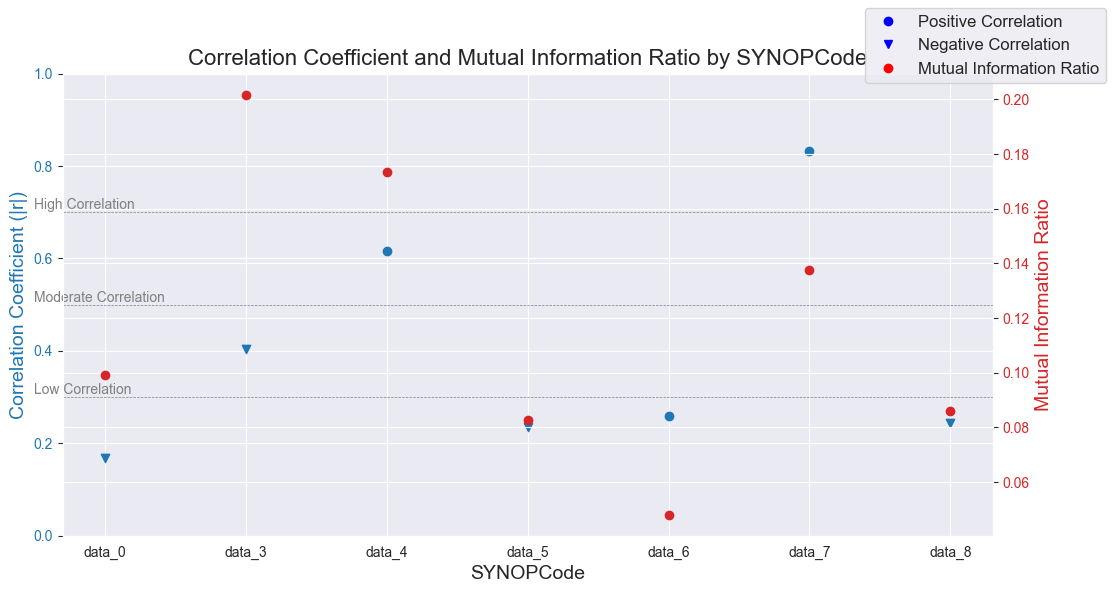

In [58]:
# Calculate Pearson correlation coefficient and mutual information
correlation_coeffs, info_ratios = [], []
for i in [0, 3, 4, 5, 6, 7, 8]:
    data_subset = data_by_synop[f'data_{i}']

    # predict for RFL and FSO model
    rfl_pred = models_rfl[f'data_{i}'].predict(data_subset[best_features_rfl[f'data_{i}']])
    fso_pred = models_fso[f'data_{i}'].predict(data_subset[best_features_fso[f'data_{i}']])

    # Calculate the Pearson correlation coefficient
    pearson_corr, _ = pearsonr(rfl_pred, fso_pred)
    correlation_coeffs.append((f'data_{i}', pearson_corr))

    # Mutual information ratio
    rfl_discretized = KBinsDiscretizer(n_bins=10, encode='ordinal').fit_transform(rfl_pred.reshape(-1, 1)).flatten()
    fso_discretized = KBinsDiscretizer(n_bins=10, encode='ordinal').fit_transform(fso_pred.reshape(-1, 1)).flatten()

    # Joint entropy
    joint_counts = np.unique(list(zip(rfl_discretized, fso_discretized)), axis=0, return_counts=True)[1]
    joint_entropy_value = entropy(joint_counts)

    # Univariate entropy
    mutual_info = entropy(np.unique(rfl_discretized, return_counts=True)[1]) + \
                  entropy(np.unique(fso_discretized, return_counts=True)[1]) - joint_entropy_value

    # Mutual information ratio
    info_ratios.append((f'data_{i}', mutual_info / joint_entropy_value if joint_entropy_value != 0 else 0))

# Extract SYNOPCode and corresponding values
synop_codes = [key for key, _ in correlation_coeffs]
correlation_values = [abs(coeff) for _, coeff in correlation_coeffs]  # 使用绝对值
info_ratio_values = [ratio for _, ratio in info_ratios]

# plot the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the Pearson correlation coefficient
ax1.set_xlabel('SYNOPCode', fontsize=14)
ax1.set_ylabel('Correlation Coefficient (|r|)', color='tab:blue', fontsize=14)

# Select shapes based on positive and negative values
for synop_code, corr_value, original_corr in zip(synop_codes, correlation_values, [coeff for _, coeff in correlation_coeffs]):
    marker = 'o' if original_corr >= 0 else 'v'
    ax1.scatter(synop_code, corr_value, color='tab:blue', label='Correlation Coeff.', marker=marker)

ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor='tab:blue')

correlation_levels = [0.7, 0.5, 0.3]
labels = ['High Correlation', 'Moderate Correlation', 'Low Correlation']

for level, label in zip(correlation_levels, labels):
    ax1.axhline(y=level, color='gray', linestyle='--', linewidth=0.5)
    ax1.text(-0.5, level, label, color='gray', verticalalignment='bottom', fontsize=10)

# Plot mutual information ratios
ax2 = ax1.twinx()
ax2.set_ylabel('Mutual Information Ratio', color='tab:red', fontsize=14)
ax2.scatter(synop_codes, info_ratio_values, color='tab:red', label='Mutual Information Ratio')
ax2.tick_params(axis='y', labelcolor='tab:red')

# title
plt.title('Correlation Coefficient and Mutual Information Ratio by SYNOPCode', fontsize=16)

handles1 = [plt.Line2D([0], [0], marker='o', color='blue', label='Positive Correlation', linestyle='None'),
            plt.Line2D([0], [0], marker='v', color='blue', label='Negative Correlation', linestyle='None')]
handles2 = [plt.Line2D([0], [0], marker='o', color='red', label='Mutual Information Ratio', linestyle='None')]

fig.legend(handles=handles1 + handles2, loc='upper right', fontsize=12)

plt.show()

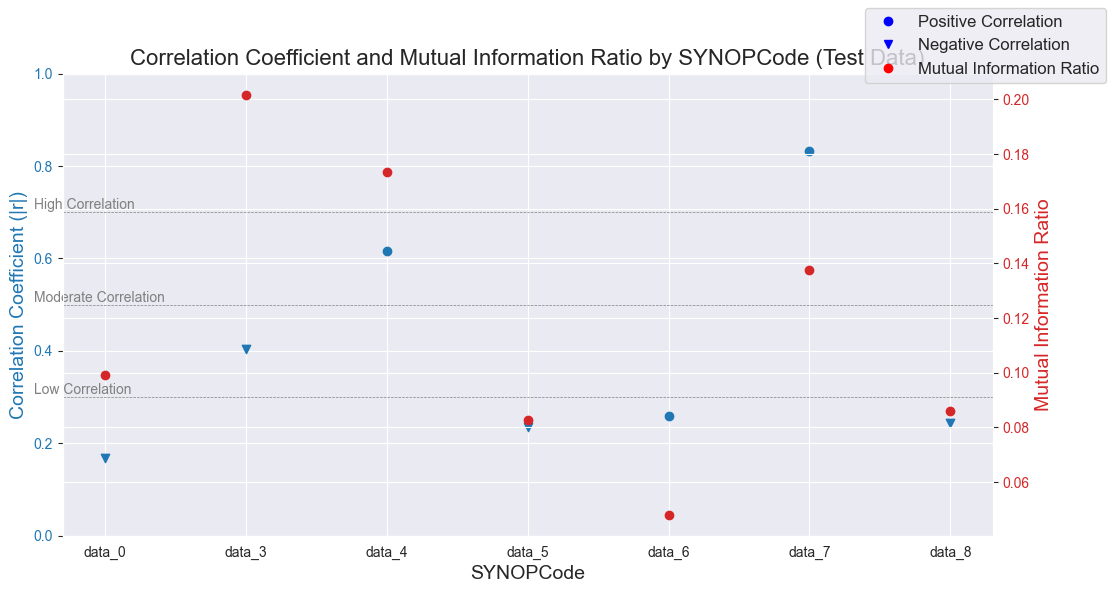

In [59]:
synop_codes = [key for key, _ in correlation_coeffs]
correlation_values = [abs(coeff) for _, coeff in correlation_coeffs]
info_ratio_values = [ratio for _, ratio in info_ratios]

# plot the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Pearson correlation coefficients (shape to distinguish positive and negative)
ax1.set_xlabel('SYNOPCode', fontsize=14)
ax1.set_ylabel('Correlation Coefficient (|r|)', color='tab:blue', fontsize=14)

for synop_code, corr_value, original_corr in zip(synop_codes, correlation_values, [coeff for _, coeff in correlation_coeffs]):
    marker = 'o' if original_corr >= 0 else 'v'
    ax1.scatter(synop_code, corr_value, color='tab:blue', label='Correlation Coeff.', marker=marker)

ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor='tab:blue')

correlation_levels = [0.7, 0.5, 0.3]
labels = ['High Correlation', 'Moderate Correlation', 'Low Correlation']

for level, label in zip(correlation_levels, labels):
    ax1.axhline(y=level, color='gray', linestyle='--', linewidth=0.5)
    ax1.text(-0.5, level, label, color='gray', verticalalignment='bottom', fontsize=10)

ax2 = ax1.twinx()
ax2.set_ylabel('Mutual Information Ratio', color='tab:red', fontsize=14)
ax2.scatter(synop_codes, info_ratio_values, color='tab:red', label='Mutual Information Ratio')
ax2.tick_params(axis='y', labelcolor='tab:red')

# title
plt.title('Correlation Coefficient and Mutual Information Ratio by SYNOPCode (Test Data)', fontsize=16)

handles1 = [plt.Line2D([0], [0], marker='o', color='blue', label='Positive Correlation', linestyle='None'),
            plt.Line2D([0], [0], marker='v', color='blue', label='Negative Correlation', linestyle='None')]
handles2 = [plt.Line2D([0], [0], marker='o', color='red', label='Mutual Information Ratio', linestyle='None')]

fig.legend(handles=handles1 + handles2, loc='upper right', fontsize=12)

plt.show()